In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using TensorFlow backend.
C:\Users\gleny\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\gleny\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\gleny\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\gleny\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# define a function to convert a vector of time series into a 2D matrix
def convertSeriesToMatrix(vectorSeries, sequence_length):
    matrix = []
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix

In [3]:

# random seed
np.random.seed(1234)

# load the data
path_to_dataset = 'convertcsv.csv'
sequence_length = 20

# vector to store the time series
vector_vix = []
with open(path_to_dataset) as f:
    next(f) # skip the header row
    for line in f:
        fields = line.split(',')
        vector_vix.append(float(fields[52]))

# convert the vector to a 2D matrix
matrix_vix = convertSeriesToMatrix(vector_vix, sequence_length)

# shift all data by mean
matrix_vix = np.array(matrix_vix)
shifted_value = matrix_vix.mean()
matrix_vix -= shifted_value
print ("Data  shape: ", matrix_vix.shape)
print(matrix_vix.shape[0])
# split dataset: 90% for training and 10% for testing
train_row = int(round(0.9 * matrix_vix.shape[0]))
train_set = matrix_vix[:train_row, :]

# shuffle the training set (but do not shuffle the test set)
np.random.shuffle(train_set)
# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1]
# the test set
X_test = matrix_vix[train_row:, :-1]
y_test = matrix_vix[train_row:, -1]

# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# build the model
model = Sequential()
# layer 1: LSTM
model.add(LSTM(units=100, input_shape=(19, 1), return_sequences=True))
model.add(Dropout(0.2))
# layer 2: LSTM
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
# linear activation: a(x) = x
model.add(Dense(units=1))
model.add(Activation('linear'))
# compile the model
model.compile(loss="mse", optimizer="rmsprop")
print(model.summary())


# train the model
model.fit(X_train, y_train, batch_size=512, epochs=50, validation_split=0.05, verbose=1)


# evaluate the result
test_mse = model.evaluate(X_test, y_test, verbose=1)
print ('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(y_test)))

# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))



Data  shape:  (1920, 20)
1920
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 19, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
__________________

NameError: name 'Y_test' is not defined

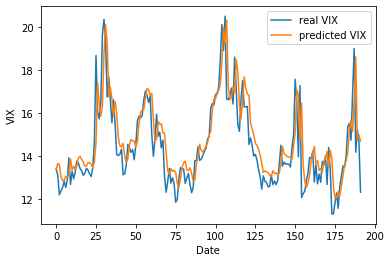

[[ 9.57390086e-04 -2.89042610e-01 -1.19904261e+00 ...  1.83095739e+00
   1.29095739e+00 -1.07904261e+00]
 [-2.57449964e-01 -5.47449964e-01 -1.45744996e+00 ...  1.57255004e+00
   1.03255004e+00 -1.33744996e+00]
 [-2.03657964e-01 -4.93657964e-01 -1.40365796e+00 ...  1.62634204e+00
   1.08634204e+00 -1.28365796e+00]
 ...
 [-1.37321744e+00 -1.66321744e+00 -2.57321744e+00 ...  4.56782557e-01
  -8.32174432e-02 -2.45321744e+00]
 [-1.58039317e+00 -1.87039317e+00 -2.78039317e+00 ...  2.49606825e-01
  -2.90393175e-01 -2.66039317e+00]
 [-1.30212937e+00 -1.59212937e+00 -2.50212937e+00 ...  5.27870632e-01
  -1.21293676e-02 -2.38212937e+00]]


In [4]:
diviation = y_test - predicted_values


# plot the results
fig = plt.figure()
plt.plot(y_test + shifted_value, label='real VIX')
plt.plot(predicted_values + shifted_value, label='predicted VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()
fig.savefig('output_prediction.jpg', bbox_inches='tight')

print(diviation
     )
# save the result into txt file
test_result = list(zip(predicted_values, y_test)) + shifted_value
np.savetxt('output_result.txt', test_result)